# Mixed Martial Arts and the UFC

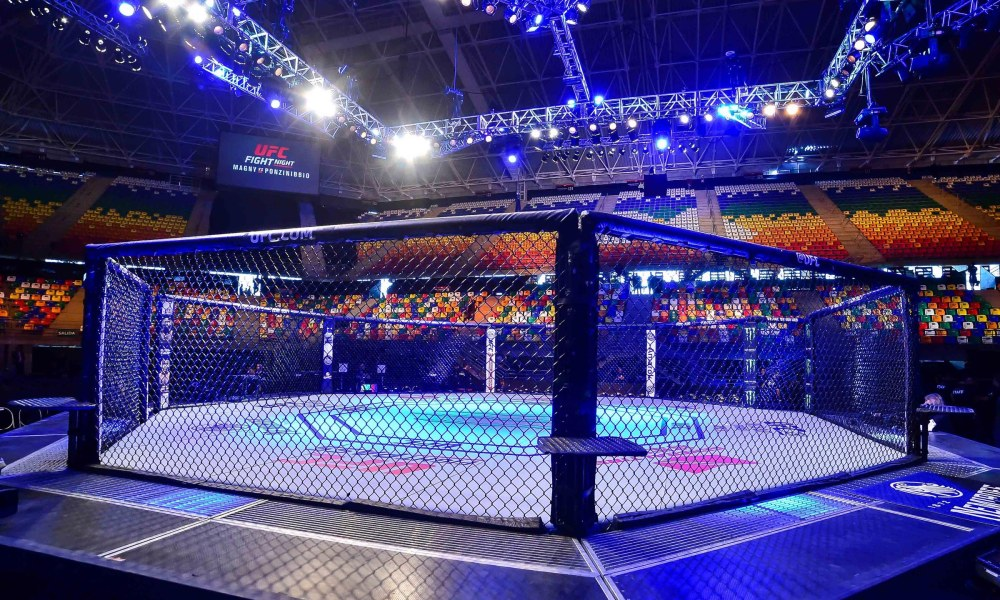

The UFC is the largest MMA promotion company in the world and features some of the highest-level fighters in the sport. As of 2020 the UFC has held over 500 events features fighters in 12 different weight divisions. The data set is a collection of over 5000 fights from the years 1993 to 2019.

Being a huge fan of MMA, I wanted to design some Machine Learning Models to experiment with the avaiable data. The goal is to make a model to predict fight outcomes, and see if it has any usefulness in real world application.

In this particular notebook I reduce the data down to (what I felt was) core stats, so despite this dataset having over 145 features, I reduce it down to height, weight, reach, win streak, lose streak, total wins, total losses, and total draws. In the future I will apply more features to see if the model accuracy improves at all.

In this notebook I use the following algorithms for model building:
* Gaussian Naive Bayes
* Logistic Regression
* Decision Tree
* KNN
* Random Forest
* Support Vector Classifier
* XGBoost
* Artificial Neural Network

The models with the highest accuracy score (Using k-fold cross-validation) on the training data are then accessed on the testing data.

Finally the models that performed well are then applied to the upcoming event (March 6th 2021), to make predictions on fight winners.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split



from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier

import keras 
from keras.models import Sequential
from keras.layers import Dense
from keras import layers, models, optimizers
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ufcdata/raw_total_fight_data.csv
/kaggle/input/ufcdata/data.csv
/kaggle/input/ufcdata/preprocessed_data.csv
/kaggle/input/ufcdata/raw_fighter_details.csv


### Import and clean data for use in models

In [2]:
data_df =  pd.read_csv('../input/ufcdata/data.csv')

In [3]:
data_df.head()

R_fighter       B_fighter          Referee        date  \
0          Henry Cejudo   Marlon Moraes     Marc Goddard  2019-06-08   
1  Valentina Shevchenko     Jessica Eye  Robert Madrigal  2019-06-08   
2         Tony Ferguson  Donald Cerrone  Dan Miragliotta  2019-06-08   
3         Jimmie Rivera        Petr Yan  Kevin MacDonald  2019-06-08   
4           Tai Tuivasa   Blagoy Ivanov  Dan Miragliotta  2019-06-08   

                 location Winner  title_bout       weight_class  no_of_rounds  \
0  Chicago, Illinois, USA    Red        True       Bantamweight             5   
1  Chicago, Illinois, USA    Red        True  Women's Flyweight             5   
2  Chicago, Illinois, USA    Red       False        Lightweight             3   
3  Chicago, Illinois, USA   Blue       False       Bantamweight             3   
4  Chicago, Illinois, USA   Blue       False        Heavyweight             3   

   B_current_lose_streak  ...  R_win_by_KO/TKO  R_win_by_Submission  \
0                    0.0  ...              2.0                  0.0   
1                    0.0  ...              0.0                  2.0   
2                    0.0  ...              3.0                  6.0   
3                    0.0  ...              1.0                  0.0   
4                    0.0  ...              2.0                  0.0   

   R_win_by_TKO_Doctor_Stoppage  R_wins  R_Stance  R_Height_cms  R_Reach_cms  \
0                           0.0     8.0  Orthodox        162.56       162.56   
1                           0.0     5.0  Southpaw        165.10       167.64   
2                           1.0    14.0  Orthodox        180.34       193.04   
3                           0.0     6.0  Orthodox        162.56       172.72   
4                           0.0     3.0  Southpaw        187.96       190.50   

   R_Weight_lbs  B_age  R_age  
0         135.0   31.0   32.0  
1         125.0   32.0   31.0  
2         155.0   36.0   35.0  
3         135.0   26.0   29.0  
4         264.0   32.0   26.0  

[5 rows x 145 columns]

In [4]:
df = data_df.dropna()

In [5]:
df.shape

(3202, 145)

For this exercise we will only use a few of the listed features, not the full 145 available in the data set. Basic stats will be used like height, weight, reach, along with recent fight streaks (wins or losses) and overall MMA record to date.

In [6]:
df_simple = df[['no_of_rounds', 
                'B_current_lose_streak', 'B_current_win_streak', 'B_draw', 'B_losses', 'B_wins', 'B_Stance', 'B_Height_cms','B_Reach_cms', 'B_Weight_lbs',
                'R_current_lose_streak', 'R_current_win_streak', 'R_draw', 'R_losses', 'R_wins', 'R_Stance', 'R_Height_cms','R_Reach_cms', 'R_Weight_lbs', 
                'Winner']]

In [7]:
df_simple.dtypes

no_of_rounds               int64
B_current_lose_streak    float64
B_current_win_streak     float64
B_draw                   float64
B_losses                 float64
B_wins                   float64
B_Stance                  object
B_Height_cms             float64
B_Reach_cms              float64
B_Weight_lbs             float64
R_current_lose_streak    float64
R_current_win_streak     float64
R_draw                   float64
R_losses                 float64
R_wins                   float64
R_Stance                  object
R_Height_cms             float64
R_Reach_cms              float64
R_Weight_lbs             float64
Winner                    object
dtype: object

Some of the string (object) features must be converted to numerical values:

In [8]:
df_simple['B_Stance'].unique()

array(['Orthodox', 'Switch', 'Southpaw', 'Open Stance'], dtype=object)

In [9]:
mapping = {'Orthodox': 0, 'Switch': 1, 'Southpaw': 2, 'Open Stance': 3}

In [10]:
df_simple['B_Stance'] = df_simple['B_Stance'].replace(mapping)
df_simple['R_Stance'] = df_simple['R_Stance'].replace(mapping)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Split the data into our X (input) and Y (output) variables

In [11]:
X = df_simple.drop(columns=['Winner'])
Y = df_simple['Winner']

In [12]:
mapping = {'Red': 0, 'Blue': 1, 'Draw': 2}
Y = Y.replace(mapping)

Split the data into training/testing sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

## Model Training and Evaluation on Data using k-fold cross validation

In [14]:
seed = 404
np.random.seed(seed)

In [15]:
gnb = GaussianNB()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(gnb, X_train, y_train.values.ravel(), cv=kfold)
print('Gaussian Naive Bayes K-fold Scores:')
print(cv_score)
print()
print('Gaussian Naive Bayes Average Score:')
print(cv_score.mean())
print()

Gaussian Naive Bayes K-fold Scores:
[0.60930233 0.61860465 0.63255814 0.59534884 0.58139535 0.52803738
 0.63551402 0.58878505 0.58878505 0.61682243]

Gaussian Naive Bayes Average Score:
0.5995153227559226



In [16]:
lr = LogisticRegression(max_iter = 2000)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(lr, X_train, y_train.values.ravel(), cv=kfold)
print('Logistic Regression K-fold Scores (training):')
print(cv_score)
print()
print('Logistic Regression Average Score:')
print(cv_score.mean())

Logistic Regression K-fold Scores (training):
[0.60465116 0.65116279 0.66511628 0.62790698 0.64651163 0.56542056
 0.61682243 0.62149533 0.64018692 0.59813084]

Logistic Regression Average Score:
0.6237404911975657


In [17]:
dt = tree.DecisionTreeClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(dt, X_train, y_train.values.ravel(), cv=kfold)
print('Decision Tree K-fold Scores:')
print(cv_score)
print()
print('Decision Tree Average Score:')
print(cv_score.mean())

Decision Tree K-fold Scores:
[0.57209302 0.55813953 0.54418605 0.5627907  0.54418605 0.57009346
 0.59345794 0.50934579 0.46728972 0.5       ]

Decision Tree Average Score:
0.542158226472506


In [18]:
knn = KNeighborsClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(knn, X_train, y_train.values.ravel(), cv=kfold)
print('KNN K-fold Scores):')
print(cv_score)
print()
print('KNN Average Score:')
print(cv_score.mean())

KNN K-fold Scores):
[0.52093023 0.58604651 0.50697674 0.5627907  0.54883721 0.54205607
 0.54672897 0.52803738 0.56074766 0.60747664]

KNN Average Score:
0.55106281243208


In [19]:
rf = RandomForestClassifier(random_state = 1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(rf, X_train, y_train.values.ravel(), cv=kfold)
print('Random Forest K-fold Scores:')
print(cv_score)
print()
print('Random Forest Average Score:')
print(cv_score.mean())

Random Forest K-fold Scores:
[0.58604651 0.60465116 0.60930233 0.6        0.59534884 0.58878505
 0.62616822 0.58411215 0.58878505 0.60280374]

Random Forest Average Score:
0.598600304281678


In [20]:
svc = SVC(probability = True)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(svc, X_train, y_train.values.ravel(), cv=kfold)
print('Support Vector Classification K-fold Scores:')
print(cv_score)
print()
print('Support Vector Classification Average Score:')
print(cv_score.mean())

Support Vector Classification K-fold Scores:
[0.62790698 0.62790698 0.62790698 0.62790698 0.62790698 0.62616822
 0.62616822 0.62616822 0.62616822 0.62616822]

Support Vector Classification Average Score:
0.6270376005216257


In [21]:
xgb = XGBClassifier(objective='multi:softmax',random_state =1, use_label_encoder=False)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cv_score = cross_val_score(xgb, X_train, y_train.values.ravel(), cv=kfold)
print('XGBoost Classifier K-fold Scores:')
print(cv_score)
print()
print('XGBoost Classifier Average Score:')
print(cv_score.mean())

[13:39:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:39:20] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [22]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_Train = np_utils.to_categorical(encoded_Y)

encoder = LabelEncoder()
encoder.fit(y_test)
y_Test = encoder.transform(y_test)


def create_model():
    model = Sequential()
    
    model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(X_train.shape[1]*2, activation='tanh'))
    model.add(Dense(X_train.shape[1]*4, activation='tanh'))
    model.add(Dense(X_train.shape[1]*2, activation='tanh'))    
    model.add(Dense(X_train.shape[1], activation='relu'))
    model.add(Dense(3, activation='sigmoid'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [23]:
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)


kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(model, X_train, y_Train, cv=kfold)
print('Neural Network K-fold Scores:')
print(cv_score)
print()
print('Neural Network Average Score:')
print(cv_score.mean())

Neural Network K-fold Scores:
[0.57209302 0.58604651 0.56744186 0.60465116 0.60465116 0.58878505
 0.58411215 0.55607477 0.60280374 0.60747664]

Neural Network Average Score:
0.587413605737883


## Best performing models

With the training accuracy in mind, we will grab the top 3 models and evaluate them on the testing set

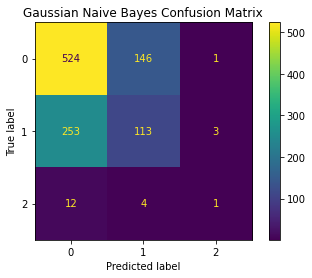

Gaussian Naive Bayes Model Accuracy (on testing set): 
0.6035950804162725


In [33]:
GNB = GaussianNB()
GNB_model = GNB.fit(X_train, y_train.values.ravel())
y_pred = GNB_model.predict(X_test)

disp = plot_confusion_matrix(GNB_model, X_test, y_test)
disp.ax_.set_title('Gaussian Naive Bayes Confusion Matrix')

plt.show()
print('Gaussian Naive Bayes Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

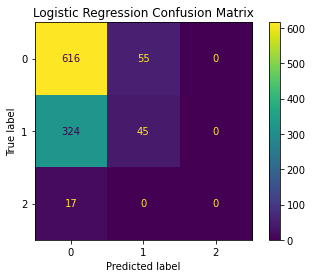

Logistic Regression Model Accuracy (on testing set): 
0.6253547776726585


In [24]:
lr = LogisticRegression(max_iter = 2000)
lr_model = lr.fit(X_train, y_train.values.ravel())
y_pred = lr_model.predict(X_test)

disp = plot_confusion_matrix(lr_model, X_test, y_test)
disp.ax_.set_title('Logistic Regression Confusion Matrix')

plt.show()
print('Logistic Regression Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

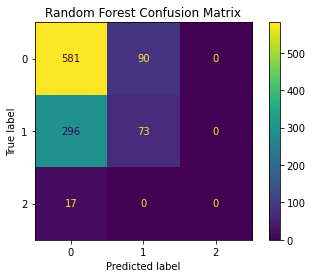

Random Forest Model Accuracy (on testing set): 
0.618732261116367


In [25]:
rf = RandomForestClassifier(random_state = 1)
rf_model = rf.fit(X_train, y_train.values.ravel())
y_pred = rf_model.predict(X_test)
disp = plot_confusion_matrix(rf_model, X_test, y_test)
disp.ax_.set_title('Random Forest Confusion Matrix')

plt.show()

print('Random Forest Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

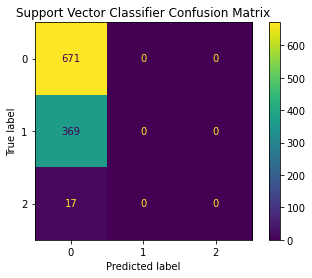

SVC Model Accuracy (on testing set): 
0.6348155156102177


In [26]:
svc = SVC(probability = True)
svc_model = svc.fit(X_train, y_train.values.ravel())
y_pred = svc_model.predict(X_test)
disp = plot_confusion_matrix(svc_model, X_test, y_test)
disp.ax_.set_title('Support Vector Classifier Confusion Matrix')

plt.show()

print('SVC Model Accuracy (on testing set): ')
print(accuracy_score(y_test, y_pred))

# Prediction Time

# UFC 259: Blachowicz vs Adesanya

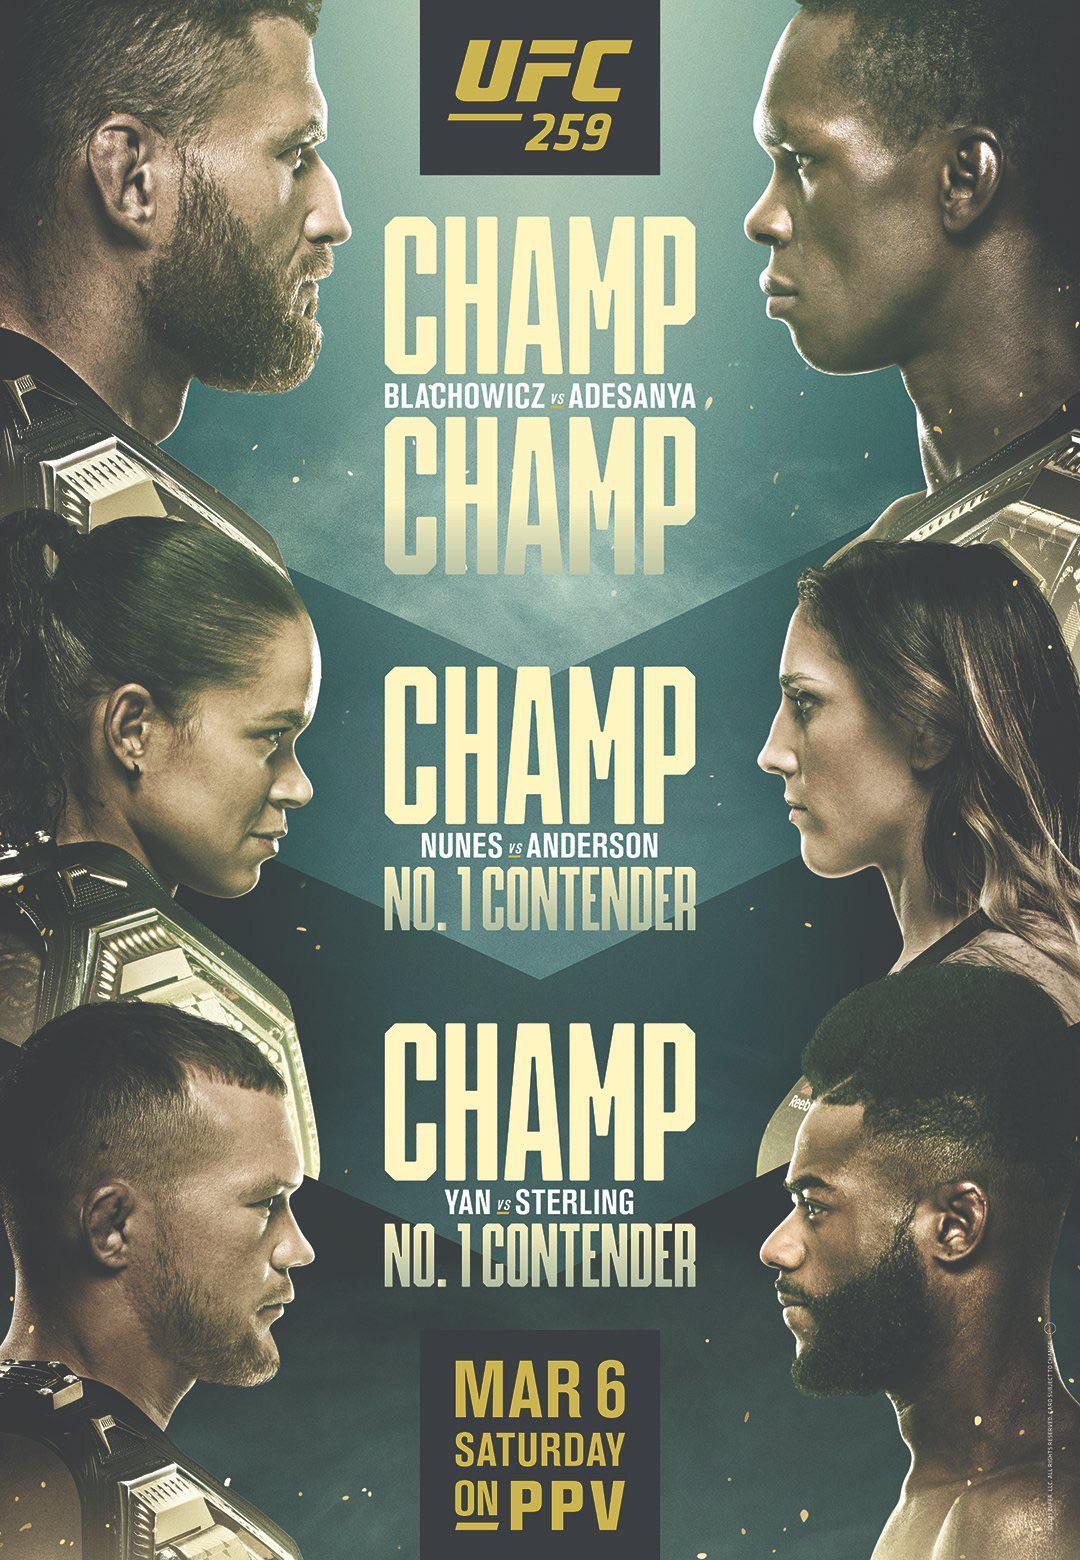

### Title fights (5 rounds):
Jan Blachowicz vs Israel Adesanya

Amanda Nunes vs Megan Anderson

Petr Yan vs Aljamain Sterling

### 3 round fights:
Islam Makhachev vs Drew Dober

Thiago Santos vs Aleksandar Rakic


## The Stats: ([https://www.espn.co.uk/mma/fightcenter/_/id/600001860/league/ufc](http://))
### Fight 1
#### Jan Blachowicz (Blue):
* Current Lose Streak: 0
* Current Win Streak: 4
* Draws: 0
* Losses: 8
* Wins: 27
* Stance: Orthodox
* Height: 188
* Reach: 198
* Weight: 205

#### Israel Adesanya (Red):
* Current Lose Streak: 0
* Current Win Streak: 20
* Draws: 0
* Losses: 0
* Wins: 20
* Stance: Switch
* Height: 193
* Reach: 203
* Weight: 193 (speculation based on interview, weigh-ins to come)


### Fight 2
#### Amanda Nunes (Blue):
* Current Lose Streak: 0
* Current Win Streak: 11
* Draws: 0
* Losses: 4
* Wins: 20
* Stance: Orthodox
* Height: 173
* Reach: 165
* Weight: 145

#### Megan Anderson (Red):
* Current Lose Streak: 0
* Current Win Streak: 2
* Draws: 0
* Losses: 4
* Wins: 11
* Stance: Orthodox
* Height: 183
* Reach: 183
* Weight: 145

### Fight 3
#### Petr Yan (Blue):
* Current Lose Streak: 0
* Current Win Streak: 10
* Draws: 0
* Losses: 1
* Wins: 15
* Stance: Switch
* Height: 170
* Reach: 170
* Weight: 135

#### Aljamain Sterling (Red):
* Current Lose Streak: 0
* Current Win Streak: 5
* Draws: 0
* Losses: 3
* Wins: 19
* Stance: Orthodox
* Height: 170
* Reach: 180
* Weight: 135

### Fight 4
#### Islam Makhachev (Blue):
* Current Lose Streak: 0
* Current Win Streak: 6
* Draws: 0
* Losses: 1
* Wins: 18
* Stance: Orthodox
* Height: 178
* Reach: 178
* Weight: 155

#### Drew Dober (Red):
* Current Lose Streak: 0
* Current Win Streak: 3
* Draws: 0
* Losses: 9
* Wins: 23
* Stance: Southpaw
* Height: 173
* Reach: 178
* Weight: 155

### Fight 5
#### Thiago Santos (Blue):
* Current Lose Streak: 2
* Current Win Streak: 0
* Draws: 0
* Losses: 8
* Wins: 21
* Stance: Orthodox
* Height: 188
* Reach: 193
* Weight: 205

#### Aleksandar Rakic (Red):
* Current Lose Streak: 0
* Current Win Streak: 1
* Draws: 0
* Losses: 2
* Wins: 13
* Stance: Orthodox
* Height: 193
* Reach: 198
* Weight: 205

With all the stats available to us, it can create a data frame to feed into our models and get predictions

In [27]:
columns = X.columns

In [28]:
fight1 = [5, 0, 4, 0, 8, 27, 0, 188, 198, 205, 0, 20, 0, 0, 20, 1, 193, 293, 193]
fight2 = [5, 0, 11, 0, 4, 20, 0, 173, 165, 145, 0, 2, 0, 4, 11, 0, 183, 183, 145]
fight3 = [5, 0, 10, 0, 1, 15, 1, 170, 170, 135, 0, 5, 0, 3, 19, 0, 170, 180, 135]
fight4 = [3, 0, 6, 0, 1, 18, 0, 178, 178, 155, 0, 3, 0, 9, 23, 2, 173, 178, 155]
fight5 = [3, 2, 0, 0, 8, 21, 0, 188, 193, 205, 0, 1, 0, 2, 13, 0, 193, 198, 205]

df = pd.DataFrame(np.array([fight1, fight2, fight3, fight4, fight5]), columns = columns)

# Model Predictions: (0 indicates Red Fighter Wins, 1 indicates Blue Fighter Wins)

## Support Vector Classifier:

In [29]:
svc_model.predict(df)

array([0, 0, 0, 0, 0])

### Predicted Winners:
* Fight 1 - Israel Adesanya
* Fight 2 - Megan Anderson
* Fight 3 - Aljamain Sterling
* Fight 4 - Drew Dober
* Fight 5 - Aleksandar Rakic

## Random Forest:

In [30]:
rf_model.predict(df)

array([0, 0, 0, 1, 0])

### Predicted Winners:
* Fight 1 - Israel Adesanya
* Fight 2 - Megan Anderson
* Fight 3 - Aljamain Sterling
* Fight 4 - Islam Makhachev
* Fight 5 - Aleksandar Rakic

## Logistic Regression:

In [31]:
lr_model.predict(df)

array([0, 0, 0, 0, 0])

### Predicted Winners:
* Fight 1 - Israel Adesanya
* Fight 2 - Megan Anderson
* Fight 3 - Aljamain Sterling
* Fight 4 - Drew Dober
* Fight 5 - Aleksandar Rakic

# Final Thoughts

If we look at the current under/over odds in the betting world, most agree with the model predictions for Fight 1 and Fight 5, but only the Random Forest is in line with the odds for Fight 4. Fight 3 has the odds at -110 to -110, so Vegas seems to be split evenly on this fight.

I hope to expand the models to take in more features, and as a fan I can't help but think strike %, take down %, take down defence %, and a number of the various other features definitely come into play when accessing winner outcome.

I wouldn't take these models straight to the bookies, but it was a fun exercise to run and explore the data/models.

On a personal note, I would never bet against Amanda Nunes or Islam Makhachev.

I hope you enjoyed this!